In [6]:
# Importing necessary libraries
import os
from dotenv import load_dotenv
from langgraph.graph import StateGraph,START,END
# from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage,HumanMessage
from langchain_core.runnables import RunnableConfig
from typing import TypedDict,List,Literal, Dict, Any
from typing_extensions import Annotated, Optional
from pydantic import BaseModel,Field
from dataclasses import dataclass, fields
from langchain.chat_models import init_chat_model
from tavily import AsyncTavilyClient
from enum import Enum
from langgraph.types import interrupt,Command
from langgraph.constants import Send
import asyncio
import operator
import uuid
from langgraph.checkpoint.memory import MemorySaver
load_dotenv()

True

In [7]:
# Loading the environment variables and model
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")
# os.environ["ANTHROPIC_API_KEY"] = os.getenv("ANTHROPIC_API_KEY")
llm = ChatGroq(model="qwen-2.5-32b",temperature=0.1)

In [8]:
# Define the states and schema models
class UserRequirement(BaseModel):
    objective: str = Field(description="A brief statement outlining the primary goal or purpose of the application.")
    functional_requirements: str = Field(description="A detailed list of specific functionalities that the application must support to meet the user's needs.")
    non_functional_requirements: str = Field(description="A list of criteria that describe the quality attributes, performance, and constraints of the application.")

class RawRequirement(BaseModel):
    raw_requirement: UserRequirement

class UserStory(BaseModel):
    title: str = Field(description="Title of this user story")
    description: str = Field(description="Description of this user story")
    acceptance: str = Field(description="Acceptance criteria to mark this user story as aceepted")
    status: Literal["ToDo","Inprogess","Done"] = Field(description="Status of the user story, whether this user story is in Done, Inprogess or todo state")    
    technical_notes: str = Field(description="Add any implementation details or technical insights for developers")
        
class UserStories(BaseModel):
    stories : List[UserStory] = Field(description="User Stories related to project")

# States
class WorkFlowInputState(TypedDict):
    raw_requirements: str

class WorkflowState(TypedDict):
    raw_requirements: str
    user_requirement: UserRequirement
    # feedback_from_owner: str
    feedback_from_user: str
    stories : list[UserStory]
    completed_stories: Annotated[list,operator.add]
    
class UserStoryState(TypedDict):
    user_requirement: UserRequirement
    stories: list[UserStory]
    feedback_from_owner: str

In [9]:
# prompts
DEFAULT_USER_REQUIREMENTS_STRUCTURE = """
Please provide your application requirements using the following structure:

1. Objective
  - Briefly describe the main goal or purpose of the application.

2. Functional Requirements
  - List the specific functionalities you want the application to have. For example:
    - Users should be able to create, view, update, and delete tasks.
    - The application should allow users to set priorities for tasks.
    - Users should be able to search and filter tasks.

3. Non-functional Requirements
  - Specify any performance, security, or usability criteria. For example:
    - The application should load and respond quickly.
    - User data should be securely stored and protected.
    - The interface should be intuitive and easy to navigate.
"""

DETAILED_USER_STORY_STRUCTURE = """
Please provide your user story using the following structured format to ensure clarity and completeness:

1. Title  
   - A short, descriptive name that summarizes the purpose of this user story.  
   - Example: "Automated Database Backup for System Reliability"

2. Description  
   - Provide additional details about the feature, functionality, or system behavior.  
   - Mention any business rules, constraints, or expected behaviors.  
   - Example:  
     - The system should perform full database backups every 24 hours.  
     - Backups should be stored securely in an encrypted cloud storage location.  
     - The system should automatically delete backups older than 30 days.  

3. Acceptance Criteria  
   - Clearly define the **conditions that must be met** for this user story to be considered complete.  
   - Each criterion should be **specific, measurable, and testable**.  
   - Example:  
     - The system must automatically back up the database every 24 hours.  
     - Backup files must be encrypted using AES-256 encryption.  
     - The system should notify the administrator via email on backup success or failure.  
     - Older backups should be automatically deleted after 30 days.     

4. Status  
   - Indicate the current progress of this user story in the development lifecycle.  
   - Options: **ToDo / Inprogress / Done**  
   - Example: **Inprogress**  

5. Technical Notes (Optional)  
   - Provide implementation details, architectural considerations, or any technical constraints developers should be aware of.  
   - Example:  
     - Use AWS SDK for S3 integration.  
     - Implement a cron job to schedule automated backups.  
     - Ensure logs are maintained for auditing backup processes.  

### Additional Guidelines:  
   - Keep each section **clear and concise**.  
   - Use **bullet points** for easy readability.  
"""

user_requirements_instructions = """
I want a user requirements that is concise and focused.

<User Requirement>
The raw requirements provided by user
{user_requirements}
</User Requirement>

<Requirement organization>
The requirement should follow the below requirement structure
{requirement_organization}
</Requirement organization>


<Task>
Generate a structural user requirements using the provided raw user requirement.

For example, a good user requirement structure might look like:
1/ objective
2/ functional requirements
3/ non functional requirements

Before returning the user requirements, go through the each section of user requirments and mention if anything is missing
</Task>

<Feedback>
Here is feedback on the user requirement structure from review (if any):
{feedback}
</Feedback>

<Format>
Call the UserRequirement tool 
</Format>

<Instructions>
If any field in the raw requirements is unclear, please generate it yourself, ensure the generation follow the mention requirement_organization structure.
</Instructions>
"""

product_owner_instructions = """
I want a structured and well-reviewed user story that aligns with product requirements.

<User Story Structure>  
The user story should follow the below structure:  
{user_story_structure}  
</User Story Structure>  

<Task>  
1. Review the provided user story and check for completeness.  
2. Ensure the story follows the correct structure, including:  
   - Title  
   - Description  
   - Acceptance Criteria  
   - Status  
   - Technical Notes (if applicable)  
3. If any field is missing or unclear, suggest improvements or generate the missing parts.  
4. Ensure that acceptance criteria are **clear, measurable, and testable**.  
5. Verify that the story aligns with business goals and technical feasibility.  
</Task>  

<Feedback>  
Here is feedback from the product owner after review (if any):  
{feedback}  
</Feedback>  

<Format>  
Call the UserStory tool.  
</Format>  

<Instructions>  
- If any field in the user story is unclear, **propose improvements** based on best practices.  
- Ensure the final user story is well-structured, **developer-friendly, and testable**.  
- Align the user story with the **product vision and business objectives**.  
</Instructions>  
"""



##### Refine the user requirements

In [10]:
def refine_user_requirments(state:WorkflowState):
    print("---- INTO THE USER REQUIREMENT NODE ----")
    raw_requirements = state["raw_requirements"]
    requirement_organization = DEFAULT_USER_REQUIREMENTS_STRUCTURE
    feedback_from_user = state.get("feedback_from_user",None)
    Requirement_Planner = ChatGroq(model="gemma2-9b-it",temperature=0.3).with_structured_output(RawRequirement)
    system_instructions = user_requirements_instructions.format(user_requirements=raw_requirements,requirement_organization=requirement_organization,feedback=feedback_from_user)
    requirement_result = Requirement_Planner.invoke([SystemMessage(content=system_instructions)]+[HumanMessage(content="Generate the user requirements as per organization given structure from the raw user requirements.")])
    return {"user_requirement":requirement_result.raw_requirement}

##### User requirement feedback

In [17]:
def human_feedback_user_requirments(state:WorkflowState) -> Command[Literal["refine_user_requirments","user_story_subgraph"]]:
    print("---- INTO THE HUMAN FEEDBACK NODE ----")
    user_req = f"""
    The user requirements are : 
    Objective : {state['user_requirement'].objective}\n
    Functional Requirement : {state['user_requirement'].functional_requirements}\n
    Non-functional Requirement : {state['user_requirement'].non_functional_requirements}\n
    """
    interrupt_message = f"""Please provide the feedback for the below user requirements.
                        \n{user_req}\nDoes the user requirements meet your needs?\nPass 'true' to approve the user requirements.\nOr, provide feedback to regenerate the user requirements:"""
    
    feedback = interrupt(value=interrupt_message)
    
    if isinstance(feedback, bool) and feedback is True:
        print("into the feedback boolean")
        return Command(goto="user_story_subgraph")
    
    elif isinstance(feedback, str):
        print("into the feedback string")
        return Command(goto="refine_user_requirments", update={"feedback_from_user": feedback})
    
    else:
        raise TypeError(f"Interrupt value of type {type(feedback)} is not supported.")

##### User Story Creation Subgraph

In [ ]:
def generate_user_stories(state:UserStoryState):
    print("---- INTO THE generate_user_story NODE ----")
    user_requirements = state[user_requirements]
    story_writer = ChatGroq(model="",temperature=0.3).with_structured_output(UserStories)
    system_message = product_owner_instructions.format()
    print(state["feedback_from_user"])
    
def product_owner_feedback(state:WorkflowState):
    print("---- INTO THE DUMMY NODE 2 ----")
    print(state["feedback_from_user"])
    
def product_owner_review(state:WorkflowState):
    print("---- INTO THE DUMMY NODE 3 ----")
    print(state["feedback_from_user"])

section_builder = StateGraph(WorkflowState)
section_builder.add_node("dummy_node_first",dummy_node_first)
section_builder.add_node("dummy_node_second",dummy_node_second)
section_builder.add_node("dummy_node_third",dummy_node_third)

section_builder.add_edge(START, "dummy_node_first")
section_builder.add_edge("dummy_node_first", "dummy_node_second")
section_builder.add_edge("dummy_node_second","dummy_node_third")

##### Build the Workflow

In [19]:
graph = StateGraph(state_schema=WorkflowState,input=WorkFlowInputState)
graph.add_node("refine_user_requirments",refine_user_requirments)
graph.add_node("human_feedback_user_requirments",human_feedback_user_requirments)
graph.add_node("user_story_subgraph",section_builder.compile())

graph.add_edge(START,"refine_user_requirments")
graph.add_edge("refine_user_requirments","human_feedback_user_requirments")
graph.add_edge("user_story_subgraph",END)

Workflow = graph.compile(MemorySaver())

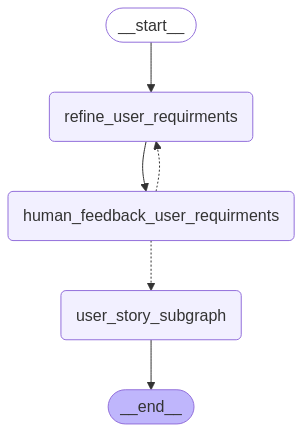

In [20]:
Workflow

In [ ]:
config = {"configurable": {"thread_id": str(uuid.uuid4())}}

In [ ]:
raw_requirements = """create a todo list application in which users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. 
Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.The application should have a simple and intuitive user interface."""
for event in Workflow.stream(input={"raw_requirements":raw_requirements},stream_mode="updates",config=config):
    if "__interrupt__" in event:
        print(event["__interrupt__"][0].value)

---- INTO THE USER REQUIREMENT NODE ----
---- INTO THE HUMAN FEEDBACK NODE ----
Please provide the feedback for the below user requirements.
                        

    The user requirements are : 
    Objective : create a todo list application

    Functional Requirement : Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.

    Non-functional Requirement : The application should have a simple and intuitive user interface.

    
Does the user requirements meet your needs?
Pass 'true' to approve the user requirements.
Or, provide feedback to regenerate the user requirements:


In [ ]:
for event in Workflow.stream(Command(resume="The application should have CRUD operations"),config=config,stream_mode="updates"):
    print(event)

---- INTO THE HUMAN FEEDBACK NODE ----
into the feedback string
{'human_feedback_user_requirments': {'feedback_from_user': 'The application should have CRUD operations'}}
---- INTO THE USER REQUIREMENT NODE ----
{'refine_user_requirements': {'user_requirement': UserRequirement(objective='create a todo list application', functional_requirements='Users should be able to create, edit, and delete tasks.Users should be able to mark tasks as completed. Users should be able to view a list of all tasks, with completed tasks visually distinguished from incomplete ones.', non_functional_requirements='The application should have a simple and intuitive user interface.')}}
---- INTO THE HUMAN FEEDBACK NODE ----
{'__interrupt__': (Interrupt(value="Please provide the feedback for the below user requirements.\n                        \n\n    The user requirements are : \n    Objective : create a todo list application\n\n    Functional Requirement : Users should be able to create, edit, and delete task

In [ ]:
for event in Workflow.stream(Command(resume=True),config=config,stream_mode="updates"):
    print(event)

---- INTO THE HUMAN FEEDBACK NODE ----
into the feedback boolean
{'human_feedback_user_requirments': None}
---- INTO THE DUMMY NODE ----
True
{'dummy_node': None}
